In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statistics
import tensorflow as tf
print(tf.__version__)
import tf_agents
import tensorflow_probability as tfp
print(tfp.__version__)
import math
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report as cr
from matplotlib import pyplot


2.9.0-dev20211224
0.16.0-dev20211226


In [2]:
# load dataset info, index by image ID:
dataset_masterfile = pd.read_csv('ImageCLEF2013PlantTask/info/ImageCLEFF2013PlantTaskMasterFileFinal.csv',delimiter=';',index_col='ImageID')

# load train & test dataset paths
train_paths = pd.read_csv('ImageCLEF2013PlantTask/info/training_path_list.csv')
test_paths = pd.read_csv('ImageCLEF2013PlantTask/info/test_path_list.csv')

/Users/lucianoaraujo/opt/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
dataset_intern_dist = [None] * 250 # 250 classes with a dict of 6 image types (dict of lists) for every class
for i in range(250):
  dataset_intern_dist[i] = {
    'NaturalLeaf': [],
    'SheetLeaf': [],    
    'Flower': [],
    'Entire': [],
    'Stem': [],
    'Fruit': []
  }

for i in range(len(train_paths.Path)):
  split = train_paths.Path[i].split('/')
  class_id = int(split[1])
  image_id = int(split[2].replace('.jpg',''))
  content = dataset_masterfile.Content[int(image_id)] # get content
  if content == 'Leaf':
      if dataset_masterfile.Type[int(image_id)] == 'SheetAsBackground':
        dataset_intern_dist[class_id]['SheetLeaf'].append(image_id)
      else:
        dataset_intern_dist[class_id]['NaturalLeaf'].append(image_id)
  else:
    dataset_intern_dist[class_id][content].append(image_id)

train_dataset_intern_dist = dataset_intern_dist

dataset_intern_dist = [None] * 250 # 250 classes with a dict of 6 image types (dict of lists) for every class
for i in range(250):
  dataset_intern_dist[i] = {
    'NaturalLeaf': [],
    'SheetLeaf': [],    
    'Flower': [],
    'Entire': [],
    'Stem': [],
    'Fruit': []
  }

for i in range(len(test_paths.Path)):
  split = test_paths.Path[i].split('/')
  class_id = int(split[1])
  image_id = int(split[2].replace('.jpg',''))
  content = dataset_masterfile.Content[int(image_id)] # get content
  if content == 'Leaf':
      if dataset_masterfile.Type[int(image_id)] == 'SheetAsBackground':
        dataset_intern_dist[class_id]['SheetLeaf'].append(image_id)
      else:
        dataset_intern_dist[class_id]['NaturalLeaf'].append(image_id)
  else:
    dataset_intern_dist[class_id][content].append(image_id)    
test_dataset_intern_dist = dataset_intern_dist    

In [8]:
''' 
Returns the number of samples in a class for a given subcategory (image type)
for a given distribution.
Categories: 
- 'NaturalLeaf'
- 'SheetLeaf'
- 'Flower'
- 'Entire'
- 'Stem'
- 'Fruit'
'''
def count_samples_in_distribution(class_id, subcategory, data_dist):
  class_dist = data_dist[class_id]
  return len(class_dist[subcategory])


''' 
  Compute subclass frequency for every class for train & test data distribution.
'''
train_leaf_class_freq = [None] * 250
train_sheet_leaf_class_freq = [None] * 250
train_flower_class_freq = [None] * 250
train_fruit_class_freq = [None] * 250
train_entire_class_freq = [None] * 250
train_stem_class_freq = [None] * 250

test_leaf_class_freq = [None] * 250
test_sheet_leaf_class_freq = [None] * 250
test_flower_class_freq = [None] * 250
test_fruit_class_freq = [None] * 250
test_entire_class_freq = [None] * 250
test_stem_class_freq = [None] * 250

mix_leaf_class_freq = [None] * 250
mix_sheet_leaf_class_freq = [None] * 250
mix_flower_class_freq = [None] * 250
mix_fruit_class_freq = [None] * 250
mix_entire_class_freq = [None] * 250
mix_stem_class_freq = [None] * 250

for i in range(250):
  train_leaf_class_freq[i] = count_samples_in_distribution(i, 'NaturalLeaf', train_dataset_intern_dist)
  train_sheet_leaf_class_freq[i] = count_samples_in_distribution(i, 'SheetLeaf', train_dataset_intern_dist)
  train_flower_class_freq[i] = count_samples_in_distribution(i, 'Flower', train_dataset_intern_dist)
  train_fruit_class_freq[i] = count_samples_in_distribution(i, 'Fruit', train_dataset_intern_dist)
  train_entire_class_freq[i] = count_samples_in_distribution(i, 'Entire', train_dataset_intern_dist)
  train_stem_class_freq[i] = count_samples_in_distribution(i, 'Stem', train_dataset_intern_dist)

  test_leaf_class_freq[i] = count_samples_in_distribution(i, 'NaturalLeaf', test_dataset_intern_dist)
  test_sheet_leaf_class_freq[i] = count_samples_in_distribution(i, 'SheetLeaf', test_dataset_intern_dist)
  test_flower_class_freq[i] = count_samples_in_distribution(i, 'Flower', test_dataset_intern_dist)
  test_fruit_class_freq[i] = count_samples_in_distribution(i, 'Fruit', test_dataset_intern_dist)
  test_entire_class_freq[i] = count_samples_in_distribution(i, 'Entire', test_dataset_intern_dist)
  test_stem_class_freq[i] = count_samples_in_distribution(i, 'Stem', test_dataset_intern_dist)

for i in range(250):
  mix_leaf_class_freq[i] = train_leaf_class_freq[i] + test_leaf_class_freq[i]
  mix_sheet_leaf_class_freq[i] = train_sheet_leaf_class_freq[i] + test_sheet_leaf_class_freq[i]
  mix_flower_class_freq[i] = train_flower_class_freq[i] + test_flower_class_freq[i]
  mix_fruit_class_freq[i] = train_fruit_class_freq[i] + test_fruit_class_freq[i] 
  mix_entire_class_freq[i] = train_entire_class_freq[i] + test_entire_class_freq[i]
  mix_stem_class_freq[i] = train_stem_class_freq[i] + test_stem_class_freq[i]
  
train_subdist = [train_leaf_class_freq, train_sheet_leaf_class_freq, train_flower_class_freq, train_fruit_class_freq, train_entire_class_freq, train_stem_class_freq]
test_subdist = [test_leaf_class_freq, test_sheet_leaf_class_freq, test_flower_class_freq, test_fruit_class_freq, test_entire_class_freq, test_stem_class_freq]  
mix_subdist = [mix_leaf_class_freq, mix_sheet_leaf_class_freq, mix_flower_class_freq, mix_fruit_class_freq, mix_entire_class_freq, mix_stem_class_freq]

# Make it a Probability distribution.
dataset_intern_probs_train = [None] * 250 # 250 classes with a dict of 6 image types (dict of lists) for every class
for i in range(250):
  dataset_intern_probs_train[i] = {
    'NaturalLeaf': 0,
    'SheetLeaf': 0,    
    'Flower': 0,
    'Entire': 0,
    'Stem': 0,
    'Fruit': 0
  }

dataset_intern_probs_test = [None] * 250 # 250 classes with a dict of 6 image types (dict of lists) for every class
for i in range(250):
  dataset_intern_probs_test[i] = {
    'NaturalLeaf': 0,
    'SheetLeaf': 0,    
    'Flower': 0,
    'Entire': 0,
    'Stem': 0,
    'Fruit': 0
  }
  
dataset_intern_probs_mix = [None] * 250 # 250 classes with a dict of 6 image types (dict of lists) for every class
for i in range(250):
  dataset_intern_probs_mix[i] = {
    'NaturalLeaf': 0,
    'SheetLeaf': 0,    
    'Flower': 0,
    'Entire': 0,
    'Stem': 0,
    'Fruit': 0
  }

k = 1 # For Laplace Smoothing
for i in range(250):
  # Compute class lenght (total no. samples)
  class_length = train_leaf_class_freq[i] + train_sheet_leaf_class_freq[i] + train_flower_class_freq[i] + train_fruit_class_freq[i] + train_entire_class_freq[i] + train_stem_class_freq[i]
  
  # Compute probabilities (Train)
  dataset_intern_probs_train[i]['NaturalLeaf'] = (train_leaf_class_freq[i] + k) / (class_length + 6 * k) 
  dataset_intern_probs_train[i]['SheetLeaf'] = (train_sheet_leaf_class_freq[i] + k) / (class_length + 6 * k)
  dataset_intern_probs_train[i]['Flower'] = (train_flower_class_freq[i] + k) / (class_length + 6 * k) 
  dataset_intern_probs_train[i]['Fruit'] = (train_fruit_class_freq[i] + k)  / (class_length + 6 * k) 
  dataset_intern_probs_train[i]['Entire'] = (train_entire_class_freq[i] + k)  / (class_length + 6 * k)
  dataset_intern_probs_train[i]['Stem'] = (train_stem_class_freq[i] + k)  / (class_length + 6 * k)

  # Compute class lenght (total no. samples)
  class_length = test_leaf_class_freq[i] + test_sheet_leaf_class_freq[i] + test_flower_class_freq[i] + test_fruit_class_freq[i] + test_entire_class_freq[i] + test_stem_class_freq[i]

  # Compute probabilities (Test)
  dataset_intern_probs_test[i]['NaturalLeaf'] = (test_leaf_class_freq[i] + k) / (class_length + 6 * k)
  dataset_intern_probs_test[i]['SheetLeaf'] = (test_sheet_leaf_class_freq[i] + k) / (class_length + 6 * k)
  dataset_intern_probs_test[i]['Flower'] = (test_flower_class_freq[i] + k) / (class_length + 6 * k) 
  dataset_intern_probs_test[i]['Fruit'] = (test_fruit_class_freq[i] + k)  / (class_length + 6 * k) 
  dataset_intern_probs_test[i]['Entire'] = (test_entire_class_freq[i] + k)  / (class_length + 6 * k)
  dataset_intern_probs_test[i]['Stem'] = (test_stem_class_freq[i] + k)  / (class_length + 6 * k)
  
  # Compute class lenght (total no. samples)
  class_length = mix_leaf_class_freq[i] + mix_sheet_leaf_class_freq[i] + mix_flower_class_freq[i] + mix_fruit_class_freq[i] + mix_entire_class_freq[i] + mix_stem_class_freq[i]
  
  # Compute probabilities (Mix = Train + Test)
  dataset_intern_probs_mix[i]['NaturalLeaf'] = 1/2 * (mix_leaf_class_freq[i] + k) / (class_length + 6 * k)
  dataset_intern_probs_mix[i]['SheetLeaf'] = 1/2 * (mix_sheet_leaf_class_freq[i] + k) / (class_length + 6 * k)
  dataset_intern_probs_mix[i]['Flower'] = 1/2 * (mix_flower_class_freq[i] + k) / (class_length + 6 * k) 
  dataset_intern_probs_mix[i]['Fruit'] = 1/2 * (mix_fruit_class_freq[i] + k)  / (class_length + 6 * k)
  dataset_intern_probs_mix[i]['Entire'] = 1/2 * (mix_entire_class_freq[i] + k)  / (class_length + 6 * k)
  dataset_intern_probs_mix[i]['Stem'] = 1/2 * (mix_stem_class_freq[i] + k)  / (class_length + 6 * k)
  

In [9]:
null_labels = [24,80,243,244,245,246,247,248,249]
label_list = list(range(250))
for i in range(len(null_labels)):
  label_list.pop(null_labels[i]-i)
  
  
train_entropies = [] # Compute the entropy with respect to every class.
for i in label_list:
  entropy = 0
  dist = dataset_intern_probs_train[i] 
  for x in dist:
    entropy = entropy + (dist[x] * np.log(1/dist[x]))
  train_entropies.append(entropy)
  
# Metric: entropy
normalized_train_entropies = [None] * len(label_list) 
  
# Normalize:
index = np.argmin(train_entropies)
min_val = train_entropies[index]
index = np.argmax(train_entropies)
max_val = train_entropies[index]
for i in range(len(label_list)): # From 0 to 241
  normalized_train_entropies[i] = (train_entropies[i] - min_val)/(max_val - min_val)

In [10]:
print(' - Classification Report:')
prediction_file = pd.read_csv('predictions_crop_and_translate.csv', delimiter=';')
y_true = prediction_file.y_true
print(cr(y_true, prediction_file.y_pred, labels=label_list,output_dict=False))
crop_trans_creport = cr(y_true, prediction_file.y_pred, labels=label_list, output_dict=True)

 - Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.57      0.63        23
           1       0.86      0.56      0.68        34
           2       0.37      0.76      0.49       104
           3       0.12      0.31      0.17        32
           4       0.17      0.45      0.25        20
           5       0.38      0.78      0.51        60
           6       0.32      0.70      0.44        50
           7       0.32      0.68      0.43        41
           8       0.77      0.69      0.73        29
           9       0.77      0.26      0.39       144
          10       0.52      0.61      0.56        18
          11       0.49      0.77      0.60       125
          12       0.46      0.52      0.49        52
          13       0.10      0.17      0.12         6
          14       0.20      0.20      0.20         5
          15       0.71      0.54      0.61        72
          16       0.49      0.77      0.60        35
 

/Users/lucianoaraujo/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lucianoaraujo/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lucianoaraujo/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [11]:
print(' - Classification Report:')
prediction_file = pd.read_csv('predictions_original.csv', delimiter=',')
y_true = prediction_file.y_true
print(cr(y_true, prediction_file.y_pred, labels=label_list,output_dict=False))
original_dataset_creport = cr(y_true, prediction_file.y_pred, labels=label_list, output_dict=True)

 - Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.61      0.38        23
           1       0.29      0.56      0.38        34
           2       0.30      0.73      0.42       104
           3       0.05      0.06      0.05        32
           4       0.00      0.00      0.00        20
           5       0.36      0.65      0.46        60
           6       0.33      0.40      0.36        50
           7       0.31      0.49      0.38        41
           8       0.61      0.59      0.60        29
           9       0.37      0.20      0.26       144
          10       0.36      0.44      0.40        18
          11       0.37      0.61      0.46       125
          12       0.61      0.38      0.47        52
          13       0.00      0.00      0.00         6
          14       0.00      0.00      0.00         5
          15       0.79      0.38      0.51        72
          16       0.39      0.40      0.39        35
 

/Users/lucianoaraujo/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lucianoaraujo/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lucianoaraujo/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [12]:
delta_f1_scores = [None] * len(label_list)
for i in range(len(label_list)):
  delta_f1_scores[i] = crop_trans_creport[str(label_list[i])]['f1-score'] - original_dataset_creport[str(label_list[i])]['f1-score']

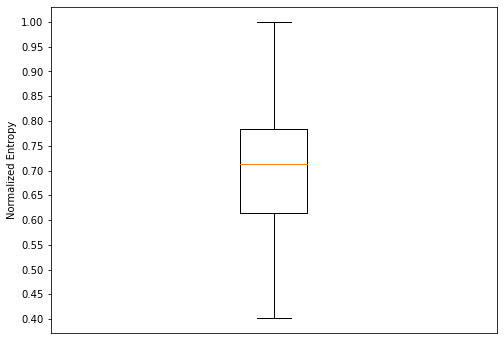

In [13]:
fig1, ax1 = plt.subplots(figsize=(8, 6)) 
plt.yticks(np.arange(0,1.05,0.05))
#plt.ylim(0.35, 1)

test = ax1.boxplot(normalized_train_entropies, showfliers=False) # Não normalizado
ax1.set_xticklabels(' ')
ax1.get_xaxis().set_visible(False)
#ax1.set_xlabel('Normalized Entropy')
ax1.set_ylabel('Normalized Entropy')
plt.savefig('normalized_entropy.jpg')
plt.show()

In [ ]:
for i in low_labels:
    low_entropy.append(normalized_train_entropies_dict[i])
for i in mid_labels:
    mid_entropy.append(normalized_train_entropies_dict[i])
for i in high_labels:
    high_entropy.append(normalized_train_entropies_dict[i])


Text(0.5, 0, 'Original Dataset F1-Micro (Test set)')

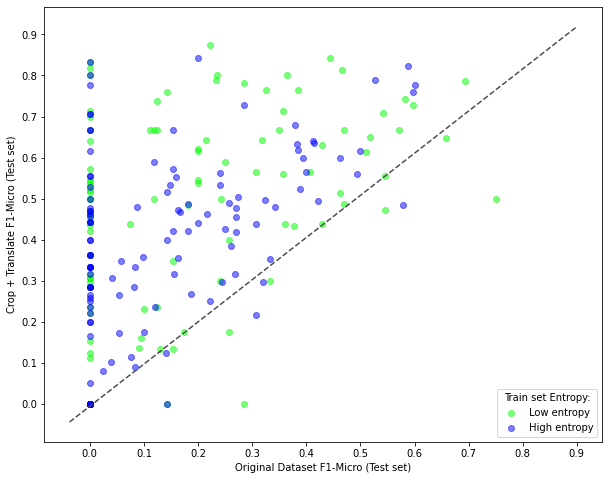

In [15]:
null_labels = [24,80,243,244,245,246,247,248,249] # Classes que não apresentaram imagens de teste

label_list = list(range(250))
for i in range(len(null_labels)):
    label_list.pop(null_labels[i]-i)

def filter_measure(measure, classification_report_dict):
    if measure == 'f1-score':
        f1_by_class = []
        for i in range(250):
          if i not in null_labels:
              i = str(i)
              f1_by_class.append(classification_report_dict[i][measure])
        return f1_by_class    

f1_original_dataset = filter_measure('f1-score', original_dataset_creport)
f1_trans_and_crop_dataset = filter_measure('f1-score', crop_trans_creport)

f1_original_dict = dict(zip(label_list, f1_original_dataset))
f1_trans_and_crop_dict = dict(zip(label_list, f1_trans_and_crop_dataset))
delta_f1_scores_dict = dict(zip(label_list, delta_f1_scores))
normalized_train_entropies_dict = dict(zip(label_list, normalized_train_entropies))

low_labels = [] # low entropy
mid_labels = [] # medium entropy
high_labels = [] # high entropy

for i in label_list:
    if normalized_train_entropies_dict[i] > 0.4 and normalized_train_entropies_dict[i] <= 0.7:
        low_labels.append(i)
    elif normalized_train_entropies_dict[i] > 0.7 and normalized_train_entropies_dict[i] <= 1:
        high_labels.append(i)
        
low_f1_or = []
mid_f1_or = []
high_f1_or = []

low_f1_crop = []
mid_f1_crop = []
high_f1_crop = []

for i in low_labels:
    low_f1_or.append(f1_original_dict[i])
    low_f1_crop.append(f1_trans_and_crop_dict[i])
        
for i in high_labels:
    high_f1_or.append(f1_original_dict[i])
    high_f1_crop.append(f1_trans_and_crop_dict[i])

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(x=low_f1_or,y=low_f1_crop,c=['#00ff00'],alpha=0.5,label='Low entropy') # verde
ax.legend()
#ax.scatter(x=mid_f1_or,y=mid_f1_crop,c=['#0000ff'],alpha=0.5,label='Medium entropy') # azul
#ax.legend()
ax.scatter(x=high_f1_or,y=high_f1_crop,c=['#0000ff'],alpha=0.5,label='High entropy') # vermelho
ax.legend(title='Train set Entropy:',loc="lower right")
plt.yticks(np.arange(0,0.901,0.1))
plt.xticks(np.arange(0,0.901,0.1))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.ylabel('Crop + Translate F1-Micro (Test set)')
plt.xlabel('Original Dataset F1-Micro (Test set)')
#plt.title('F1 x F1: Crop + Translate vs Original Dataset')
#plt.savefig('/Users/lucianoaraujo/Desktop/f1xf1.jpg')
#plt.show()


In [18]:
print(len(low_labels))
len(high_labels)

104


127

In [22]:
normalized_train_entropies_dict

{0: 0.8085056294268748,
 1: 0.7113767440137828,
 2: 0.7706106759333253,
 3: 0.8018424318693658,
 4: 0.32298774456979323,
 5: 0.6944456869875806,
 6: 0.5599378315274626,
 7: 0.619591036460283,
 8: 0.6797295484837801,
 9: 0.7742353292933535,
 10: 0.737170813763107,
 11: 0.7957659861250268,
 12: 0.6785157001518045,
 13: 0.6642191651711207,
 14: 0.7849789829568479,
 15: 0.6410380744668438,
 16: 0.7831244445702454,
 17: 0.8916119949200296,
 18: 0.8575811680402465,
 19: 0.5728630885012289,
 20: 0.8396066800787192,
 21: 0.5486480778561934,
 22: 0.8831442533684086,
 23: 0.8540358556879168,
 25: 0.8166840445726796,
 26: 0.6511047957144478,
 27: 0.6321477088415836,
 28: 0.8630357647997213,
 29: 0.6598359926440279,
 30: 0.574323315645648,
 31: 0.7154586411910809,
 32: 0.8230252435099765,
 33: 0.8704265809098544,
 34: 0.8752860577035957,
 35: 0.7258896612445178,
 36: 0.9096692704644636,
 37: 0.5878773125139961,
 38: 0.885232121654282,
 39: 0.6885287952729368,
 40: 0.3124554272099145,
 41: 0.740044

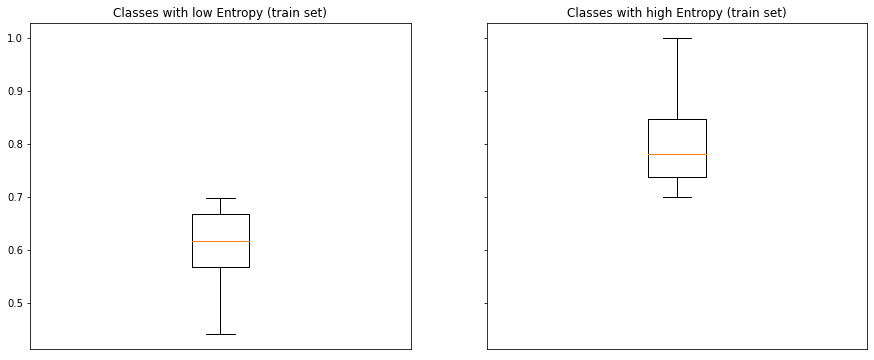

In [30]:
fig, axes = pyplot.subplots(ncols=2, figsize=(15, 6), sharey=True)
#pyplot.yticks(np.arange(0, 0.401,0.025))

low_distances = []
for i in range(len(low_labels)):
  low_distances.append(normalized_train_entropies_dict[low_labels[i]])

high_distances = []
for i in range(len(high_labels)):
  high_distances.append(normalized_train_entropies_dict[high_labels[i]])

axes[0].set_title('Classes with low Entropy (train set)')
axes[0].boxplot(low_distances,showfliers=False)
axes[0].get_xaxis().set_visible(False)

axes[1].set_title('Classes with high Entropy (train set)')
axes[1].boxplot(high_distances, showfliers=False)
axes[1].get_xaxis().set_visible(False)

low_entropy = low_distances
high_entropy = high_distances

# Para cada categoria apresenta os intervalos:

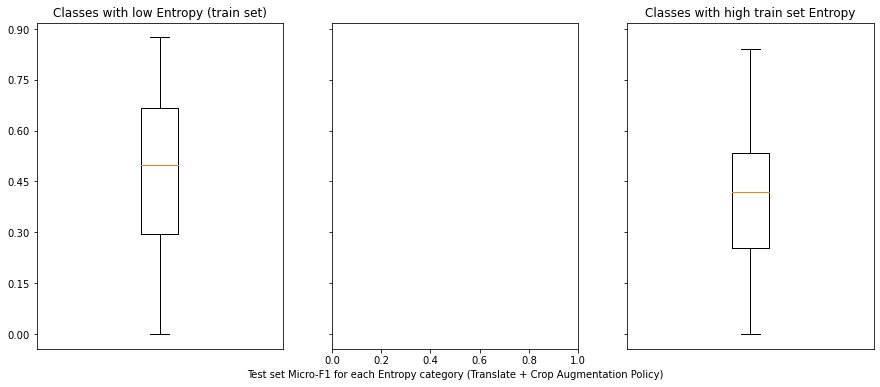

In [40]:
fig, axes = pyplot.subplots(ncols=3, figsize=(15, 6), sharey=True)
pyplot.yticks(np.arange(0, 1.05,0.15))

axes[0].set_title('Classes with low Entropy (train set)')
axes[0].boxplot(low_f1_crop)
axes[0].get_xaxis().set_visible(False)
axes[1].set_xlabel('Test set Micro-F1 for each Entropy category (Translate + Crop Augmentation Policy)')

axes[2].set_title('Classes with high train set Entropy')
axes[2].boxplot(high_f1_crop, showfliers=False)
axes[2].get_xaxis().set_visible(False)

# Obs: F1 do melhor método pode não ser a melhor medida pois não captura a informação relativa ao ganho
# de performance proporcionada pela utilização de aumento.

/Users/lucianoaraujo/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


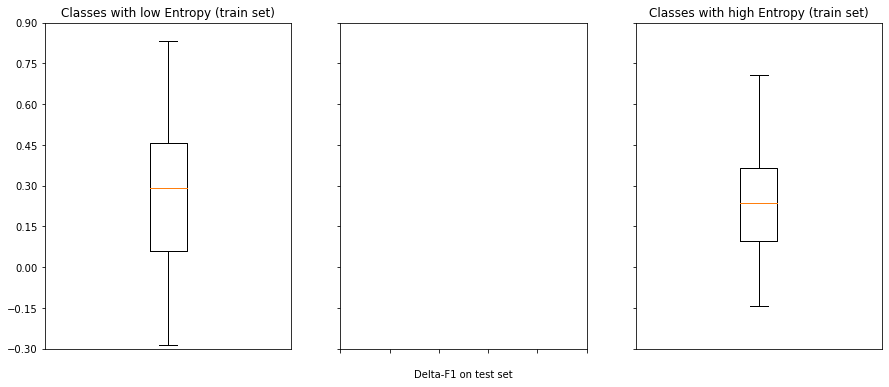

Low Entropy Classes Statistics:
Entropy mean:  0.6058246048114431  Std:  0.07223670166917767
Delta F1 mean:  0.274226693126905  Std:  0.2452608556682111
--------------------------------------------------------------

High Entropy Classes Statistics:
Entropy mean:  0.7974844387515304  Std:  0.06961349819987163
Delta F1 mean:  0.25051285594327855  Std:  0.20194812894211417
--------------------------------------------------------------


In [41]:
# Merging two analysis above in one metric (delta-f1)
fig, axes = pyplot.subplots(ncols=3, figsize=(15, 6), sharey=True)
pyplot.yticks(np.arange(-0.3, 1.05,0.15))
plt.ylim(-0.3, 0.9)
low_distances = []
for i in low_labels: # low_labels: labels with low entropy
  low_distances.append(delta_f1_scores_dict[i]) # Append delta-f1 values for classes with low entropy

high_distances = []
for i in high_labels:
  high_distances.append(delta_f1_scores_dict[i])

axes[0].set_title('Classes with low Entropy (train set)')
axes[0].boxplot(low_distances)
axes[0].get_xaxis().set_visible(False)

axes[1].set_xticklabels(' ')
axes[1].set_xlabel('Delta-F1 on test set')

axes[2].set_title('Classes with high Entropy (train set)')
axes[2].boxplot(high_distances, showfliers=False)
axes[2].get_xaxis().set_visible(False)
plt.show()
# Permite avaliar a melhoria de desempenho proporcionada pela utilização de aumento para o melhor método,
# agrupado por classes de acordo com os respectivos níveis de desbalanceamento interno.
def mean_and_std(arr):
  return np.mean(arr), np.std(arr)

low_entropy = []
high_entropy = []

for i in low_labels:
    low_entropy.append(normalized_train_entropies_dict[i])
for i in high_labels:
    high_entropy.append(normalized_train_entropies_dict[i])

low_entropy_mean, std = mean_and_std(low_entropy)
low_f1_mean, f1_std = mean_and_std(low_distances)
print("Low Entropy Classes Statistics:")
print("Entropy mean: ", low_entropy_mean, ' Std: ',std)
print("Delta F1 mean: ", low_f1_mean, ' Std: ', f1_std)
print('--------------------------------------------------------------')
print('')

#medium_entropy_mean, std = mean_and_std(mid_entropy)
#medium_f1_mean, f1_std = mean_and_std(medium_distances)
#print("Medium Entropy Classes Statistics:")
#print("Entropy mean: ", medium_entropy_mean, ' Std: ',std)
#print("Delta F1 mean: ", medium_f1_mean, ' Std: ', f1_std)
#print('--------------------------------------------------------------')
#print('')

high_entropy_mean, std = mean_and_std(high_entropy)
high_f1_mean, f1_std = mean_and_std(high_distances)
print("High Entropy Classes Statistics:")
print("Entropy mean: ", high_entropy_mean, ' Std: ',std)
print("Delta F1 mean: ", high_f1_mean, ' Std: ', f1_std)
print('--------------------------------------------------------------')